In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timm
import torch
import torch.nn as nn

from scipy.spatial import distance
import seaborn as sns

/home/co-dutt1/.conda/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def disable_module(module):
    for p in module.parameters():
        p.requires_grad = False
        
def enable_module(module):
    for p in module.parameters():
        p.requires_grad = True


def check_tunable_params(model, verbose=True):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    
    for name, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            if(verbose):
                print(name)
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.5f}"
    )

    return trainable_params, all_param

def create_mapping(model, vector):
    mapping = {}
    i = 0

    for name_p,p in model.named_parameters():
        if '.attn.' in name_p or 'attention' in name_p:
            mapping[name_p] = vector[i]
            i += 1
        else:
            p.requires_grad = False
            
    return mapping

def sort_dict(dict, descending=False):
    sorted_dict = dict(sorted(dict.items(), key=lambda item: item[1], reverse=descending))
    
    return sorted_dict

def get_modules_from_vector(vector, model):
    trainable_blocks = []
    frozen_blocks = []
    
    trainable_blocks = np.where(np.array(vector) == 1)
    frozen_blocks = np.where(np.array(vector) == 0)
    
    return trainable_blocks, frozen_blocks

def get_model_for_bitfit(model):
    trainable_components = ['bias', 'pooler.dense.bias', 'head'] 

    # Disale all the gradients
    for param in model.parameters():
        param.requires_grad = False 
      
    vector = []

    for name, param in model.named_parameters():
        for component in trainable_components:
            if component in name:
                vector.append(1)
                param.requires_grad = True
                break
    
    return vector

def enable_from_vector(vector, model):
    print("Vector: ", vector)
    
    disable_module(model)
    
    for idx, block in enumerate(model.blocks): 
    
        if(vector[idx] == 1):
            print("Enabling attention in Block {}".format(idx))
            enable_module(block.attn)
        else:
            #print("Disabling attention in Block {}".format(idx))
            disable_module(block.attn)

def create_best_worst_vectors(df, k=10):
    best_df = df.sort_values(by=['Test Acc@1'], ascending=False).head(k).reset_index(drop=True)
    worst_df = df.sort_values(by=['Test Acc@1'], ascending=True).head(k).reset_index(drop=True)

    best_vector = np.array([0]*12)

    for i in range(len(best_df)):
        vector_path = best_df['Vector Path'][i]
        vector = np.load(vector_path)
        best_vector += vector

    worst_vector = np.array([0]*12)

    for i in range(len(worst_df)):
        vector_path = worst_df['Vector Path'][i]
        vector = np.load(vector_path)
        worst_vector += vector

    return best_vector, worst_vector

In [3]:
def last_row_to_first(df):
    last_row = df.iloc[-1]
    df = pd.concat([last_row.to_frame().T, df], ignore_index=True)
    df = df.drop(df.index[-1]).reset_index(drop=True)

    return df

def get_best_row(df):
    best_row = df.sort_values(by=['Test Acc@1'], ascending=False).head(1).reset_index(drop=True)
    return best_row

In [4]:
base_path = '/home/co-dutt1/rds/hpc-work/Layer-Masking/'

csv_name = 'Fixed_Vectors_tune_attention_blocks_random_vit_base_ssl_0.0001.csv'
csv_name2 = 'Fixed_Vectors_tune_attention_vit_base_ssl.csv'
model = 'vit_base_ssl'

dataset = 'breastUS'
csv = os.path.join(base_path, model, dataset, csv_name)
csv2 = os.path.join(base_path, model, dataset, csv_name2)
df_breastUS = pd.read_csv(csv)
df2 = pd.read_csv(csv2)
best_row = get_best_row(df2)
df_breastUS = df_breastUS.append(best_row, ignore_index=True)
df_breastUS = last_row_to_first(df_breastUS)

dataset = 'fitzpatrick'
csv = os.path.join(base_path, model, dataset, csv_name)
csv2 = os.path.join(base_path, model, dataset, csv_name2)
df_fitzpatrick = pd.read_csv(csv)
df2 = pd.read_csv(csv2)
best_row = get_best_row(df2)
df_fitzpatrick = df_fitzpatrick.append(best_row, ignore_index=True)
df_fitzpatrick = last_row_to_first(df_fitzpatrick)

dataset = 'HAM10000'
csv = os.path.join(base_path, model, dataset, csv_name)
csv2 = os.path.join(base_path, model, dataset, csv_name2)
df_ham10k = pd.read_csv(csv)
df2 = pd.read_csv(csv2)
best_row = get_best_row(df2)
df_ham10k = df_ham10k.append(best_row, ignore_index=True)
df_ham10k = last_row_to_first(df_ham10k)

dataset = 'smdg'
csv = os.path.join(base_path, model, dataset, csv_name)
csv2 = os.path.join(base_path, model, dataset, csv_name2)
df_smdg = pd.read_csv(csv)
df2 = pd.read_csv(csv2)
best_row = get_best_row(df2)
df_smdg = df_smdg.append(best_row, ignore_index=True)
df_smdg = last_row_to_first(df_smdg)

dataset = 'retinopathy'
csv = os.path.join(base_path, model, dataset, csv_name)
csv2 = os.path.join(base_path, model, dataset, csv_name2)
df_retinopathy = pd.read_csv(csv)
df2 = pd.read_csv(csv2)
best_row = get_best_row(df2)
df_retinopathy = df_retinopathy.append(best_row, ignore_index=True)
df_retinopathy = last_row_to_first(df_retinopathy)

dataset = 'CIFAR10'
csv = os.path.join(base_path, model, dataset, csv_name)
csv2 = os.path.join(base_path, model, dataset, csv_name2)
df_CIFAR10 = pd.read_csv(csv)
df2 = pd.read_csv(csv2)
best_row = get_best_row(df2)
df_CIFAR10 = df_CIFAR10.append(best_row, ignore_index=True)
df_CIFAR10 = last_row_to_first(df_CIFAR10)

dataset = 'CIFAR100'
csv = os.path.join(base_path, model, dataset, csv_name)
csv2 = os.path.join(base_path, model, dataset, csv_name2)
df_CIFAR100 = pd.read_csv(csv)
df2 = pd.read_csv(csv2)
best_row = get_best_row(df2)
df_CIFAR100 = df_CIFAR100.append(best_row, ignore_index=True)
df_CIFAR100 = last_row_to_first(df_CIFAR100)

dataset = 'pneumonia'
csv = os.path.join(base_path, model, dataset, csv_name)
csv2 = os.path.join(base_path, model, dataset, csv_name2)
df_pneumonia = pd.read_csv(csv)
df2 = pd.read_csv(csv2)
best_row = get_best_row(df2)
df_pneumonia = df_pneumonia.append(best_row, ignore_index=True)
df_pneumonia = last_row_to_first(df_pneumonia)

df_pneumonia.head()

dataset_dict = {'breastUS': df_breastUS, 'fitzpatrick': df_fitzpatrick, 'HAM10000': df_ham10k, 'smdg': df_smdg, 'retinopathy': df_retinopathy, 'CIFAR10': df_CIFAR10, 'CIFAR100': df_CIFAR100, 'pneumonia': df_pneumonia}


/tmp/ipykernel_10480/4000343330.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_breastUS = df_breastUS.append(best_row, ignore_index=True)
/tmp/ipykernel_10480/4000343330.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_fitzpatrick = df_fitzpatrick.append(best_row, ignore_index=True)
/tmp/ipykernel_10480/4000343330.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ham10k = df_ham10k.append(best_row, ignore_index=True)
/tmp/ipykernel_10480/4000343330.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_smdg = df_smdg.append(best_row, ignore_index=True)
/tmp/ipykernel_10480/4000343330.py:49: FutureWarning: The fram

In [5]:
print(len(df_breastUS), len(df_fitzpatrick), len(df_ham10k), len(df_retinopathy), len(df_CIFAR10), len(df_smdg))

76 76 76 76 76 76


### How does selective attention fine-tuning compare to full-attention fine-tuning?

In [6]:
best_performance = []
full_attention = []

for dataset in dataset_dict.keys():
    df = dataset_dict[dataset]
    print("Dataset: ", dataset)
    print("Best Performing Method: ", df[df['Test Acc@1'] == df['Test Acc@1'].max()]['Tuning Method'].values[0])
    print("Best Test Acc: ", df['Test Acc@1'].max())
    print("Full Attention FT: ", df[df['Tuning Method'] == 'tune_attention']['Test Acc@1'].values[0])
    print("Difference: ", df['Test Acc@1'].max() - df[df['Tuning Method'] == 'tune_attention']['Test Acc@1'].values[0])
    print("\n")
    best_performance.append(df['Test Acc@1'].max())
    full_attention.append(df[df['Tuning Method'] == 'tune_attention']['Test Acc@1'].values[0])

Dataset:  breastUS
Best Performing Method:  tune_attention_blocks_random
Best Test Acc:  89.6103896103896
Full Attention FT:  83.11688311688312
Difference:  6.493506493506487


Dataset:  fitzpatrick
Best Performing Method:  tune_attention_blocks_random
Best Test Acc:  84.32229856339788
Full Attention FT:  79.45034353529044
Difference:  4.871955028107436


Dataset:  HAM10000
Best Performing Method:  tune_attention_blocks_random
Best Test Acc:  93.4065934065934
Full Attention FT:  91.30869130869132
Difference:  2.097902097902079


Dataset:  smdg
Best Performing Method:  tune_attention_blocks_random
Best Test Acc:  90.42207792207792
Full Attention FT:  89.04220779220779
Difference:  1.3798701298701275


Dataset:  retinopathy
Best Performing Method:  tune_attention_blocks_random
Best Test Acc:  73.57630979498862
Full Attention FT:  57.06150341685649
Difference:  16.51480637813213


Dataset:  CIFAR10
Best Performing Method:  tune_attention_blocks_random
Best Test Acc:  98.44
Full Attention 

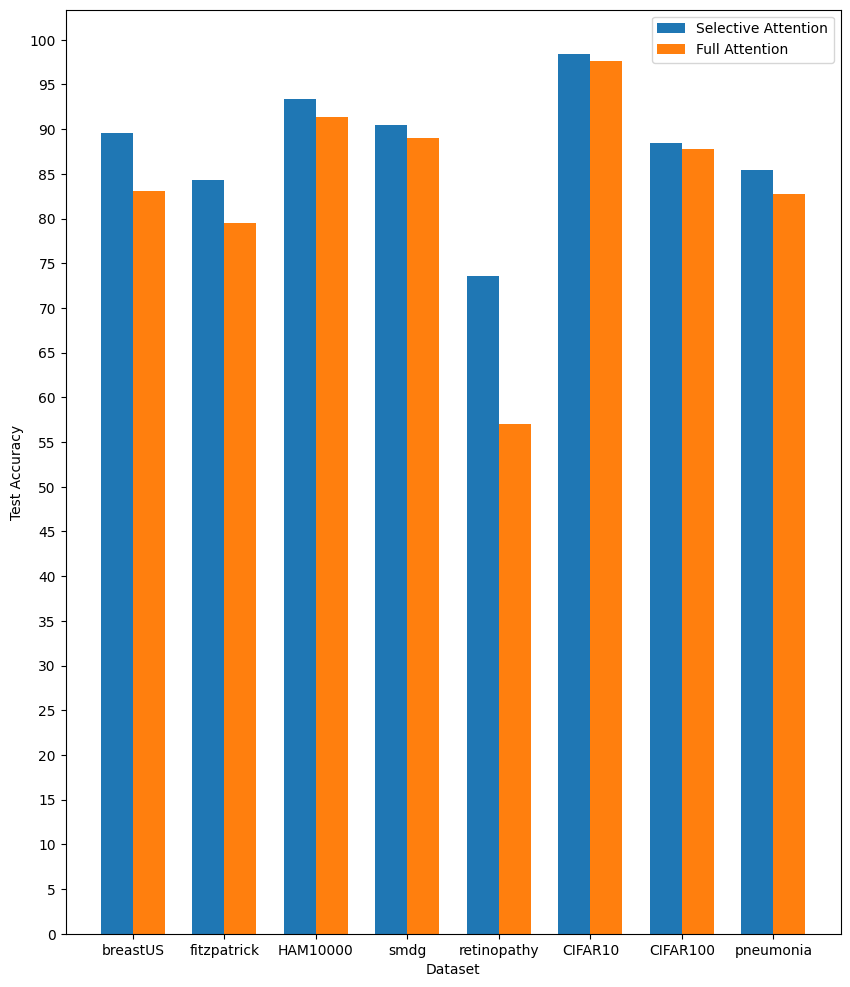

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Set the width of the bars
bar_width = 0.35

# Calculate the x-axis positions for the bars
x = np.arange(len(dataset_dict.keys()))
y = np.arange(0, 101, 5)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 12))

# Difference between the two bars
diff = np.array(best_performance) - np.array(full_attention)

# Plot the bars
ax.bar(x - bar_width/2, best_performance, width=bar_width, label='Selective Attention')
ax.bar(x + bar_width/2, full_attention, width=bar_width, label='Full Attention')

# Set the x-axis tick positions and labels
ax.set_xticks(x)
ax.set_yticks(y)
ax.set_xticklabels(list(dataset_dict.keys()))
ax.set_yticklabels(list(range(0, 101, 5)))
ax.set_xlabel('Dataset')
ax.set_ylabel('Test Accuracy')

# Set the legend
ax.legend()

# Display the plot
#plt.show()

plt.savefig('../plots/SSL_selective_vs_full_attention.png')


### Comparing Block Selection b/w best and worst performing vectors

In [8]:
# Sort all the dataframes

k = 10

all_datasets = [df_breastUS, df_fitzpatrick, df_smdg, df_ham10k, df_retinopathy, df_CIFAR10, df_CIFAR100, df_pneumonia]
_best = np.array([0]*12)
_worst = np.array([0]*12)

for df in all_datasets:
    best_vector, worst_vector = create_best_worst_vectors(df)
    _best += best_vector
    _worst += worst_vector

_best

array([39, 47, 44, 39, 48, 50, 43, 46, 36, 36, 40, 48])

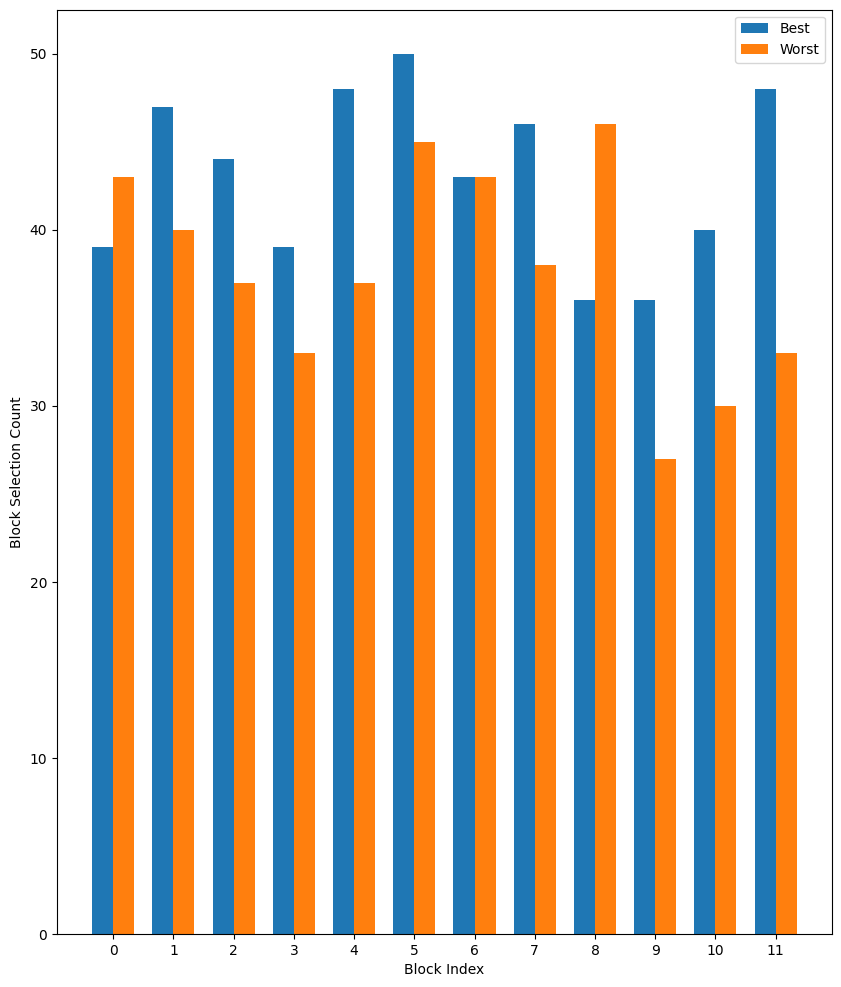

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Set the width of the bars
bar_width = 0.35

# Calculate the x-axis positions for the bars
x = np.arange(len(_best))

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 12))

# Plot the bars
ax.bar(x - bar_width/2, _best, width=bar_width, label='Best')
ax.bar(x + bar_width/2, _worst, width=bar_width, label='Worst')

# Set the x-axis tick positions and labels
ax.set_xticks(x)
ax.set_xticklabels(list(range(0,12)))
ax.set_xlabel('Block Index')
ax.set_ylabel('Block Selection Count')

# Set the legend
ax.legend()

# Display the plot
#plt.show()

plt.savefig('../plots/SSL_best_worst_blocks_selection_supervised_vitB.png')


## Ranking the vectors for each dataset

#### Do we have common vectors for best (and worst) performance?

In [10]:
k = 10

best_df_breastUS = df_breastUS.sort_values(by=['Test Acc@1'], ascending=False).head(k).reset_index(drop=True)
worst_df_breastUS = df_breastUS.sort_values(by=['Test Acc@1'], ascending=True).head(k).reset_index(drop=True)
best_df_breastUS['Vector Index'] =  best_df_breastUS['Vector Path'].apply(lambda x: x.split('/')[-1].split('_')[-1].strip('.npy')).astype(int).astype(int)
worst_df_breastUS['Vector Index'] =  worst_df_breastUS['Vector Path'].apply(lambda x: x.split('/')[-1].split('_')[-1].strip('.npy')).astype(int).astype(int)

best_df_fitzpatrick = df_fitzpatrick.sort_values(by=['Test Acc@1'], ascending=False).head(k).reset_index(drop=True)
worst_df_fitzpatrick = df_fitzpatrick.sort_values(by=['Test Acc@1'], ascending=True).head(k).reset_index(drop=True)
best_df_fitzpatrick['Vector Index'] =  best_df_fitzpatrick['Vector Path'].apply(lambda x: x.split('/')[-1].split('_')[-1].strip('.npy')).astype(int)
worst_df_fitzpatrick['Vector Index'] =  worst_df_fitzpatrick['Vector Path'].apply(lambda x: x.split('/')[-1].split('_')[-1].strip('.npy')).astype(int)

best_df_ham10k = df_ham10k.sort_values(by=['Test Acc@1'], ascending=False).head(k).reset_index(drop=True)
worst_df_ham10k = df_ham10k.sort_values(by=['Test Acc@1'], ascending=True).head(k).reset_index(drop=True)
best_df_ham10k['Vector Index'] =  best_df_ham10k['Vector Path'].apply(lambda x: x.split('/')[-1].split('_')[-1].strip('.npy')).astype(int)
worst_df_ham10k['Vector Index'] =  worst_df_ham10k['Vector Path'].apply(lambda x: x.split('/')[-1].split('_')[-1].strip('.npy')).astype(int)

best_df_retinopathy = df_retinopathy.sort_values(by=['Test Acc@1'], ascending=False).head(k).reset_index(drop=True)
worst_df_retinopathy = df_retinopathy.sort_values(by=['Test Acc@1'], ascending=True).head(k).reset_index(drop=True)
best_df_retinopathy['Vector Index'] =  best_df_retinopathy['Vector Path'].apply(lambda x: x.split('/')[-1].split('_')[-1].strip('.npy')).astype(int)
worst_df_retinopathy['Vector Index'] =  worst_df_retinopathy['Vector Path'].apply(lambda x: x.split('/')[-1].split('_')[-1].strip('.npy')).astype(int)

best_df_CIFAR10 = df_CIFAR10.sort_values(by=['Test Acc@1'], ascending=False).head(k).reset_index(drop=True)
worst_df_CIFAR10 = df_CIFAR10.sort_values(by=['Test Acc@1'], ascending=True).head(k).reset_index(drop=True)
best_df_CIFAR10['Vector Index'] =  best_df_CIFAR10['Vector Path'].apply(lambda x: x.split('/')[-1].split('_')[-1].strip('.npy')).astype(int)
worst_df_CIFAR10['Vector Index'] =  worst_df_CIFAR10['Vector Path'].apply(lambda x: x.split('/')[-1].split('_')[-1].strip('.npy')).astype(int)

best_df_CIFAR100 = df_CIFAR100.sort_values(by=['Test Acc@1'], ascending=False).head(k).reset_index(drop=True)
worst_df_CIFAR100 = df_CIFAR100.sort_values(by=['Test Acc@1'], ascending=True).head(k).reset_index(drop=True)
best_df_CIFAR100['Vector Index'] =  best_df_CIFAR100['Vector Path'].apply(lambda x: x.split('/')[-1].split('_')[-1].strip('.npy')).astype(int)
worst_df_CIFAR100['Vector Index'] =  worst_df_CIFAR100['Vector Path'].apply(lambda x: x.split('/')[-1].split('_')[-1].strip('.npy')).astype(int)

best_df_pneumonia = df_pneumonia.sort_values(by=['Test Acc@1'], ascending=False).head(k).reset_index(drop=True)
worst_df_pneumonia = df_pneumonia.sort_values(by=['Test Acc@1'], ascending=True).head(k).reset_index(drop=True)
best_df_pneumonia['Vector Index'] =  best_df_pneumonia['Vector Path'].apply(lambda x: x.split('/')[-1].split('_')[-1].strip('.npy')).astype(int)
worst_df_pneumonia['Vector Index'] =  worst_df_pneumonia['Vector Path'].apply(lambda x: x.split('/')[-1].split('_')[-1].strip('.npy')).astype(int)

best_df_smdg = df_smdg.sort_values(by=['Test Acc@1'], ascending=False).head(k).reset_index(drop=True)
worst_df_smdg = df_smdg.sort_values(by=['Test Acc@1'], ascending=True).head(k).reset_index(drop=True)
best_df_smdg['Vector Index'] =  best_df_smdg['Vector Path'].apply(lambda x: x.split('/')[-1].split('_')[-1].strip('.npy')).astype(int)
worst_df_smdg['Vector Index'] =  worst_df_smdg['Vector Path'].apply(lambda x: x.split('/')[-1].split('_')[-1].strip('.npy')).astype(int)

In [11]:
set_breastUS_best = set(best_df_breastUS['Vector Index'])
set_fitzpatrick_best = set(best_df_fitzpatrick['Vector Index'])
set_ham10k_best = set(best_df_ham10k['Vector Index'])
set_retinopathy_best = set(best_df_retinopathy['Vector Index'])
set_CIFAR10_best = set(best_df_CIFAR10['Vector Index'])
set_CIFAR100_best = set(best_df_CIFAR100['Vector Index'])
set_pneumonia_best = set(best_df_pneumonia['Vector Index'])
set_smdg_best = set(best_df_smdg['Vector Index'])

set_breastUS_worst = set(worst_df_breastUS['Vector Index'])
set_fitzpatrick_worst = set(worst_df_fitzpatrick['Vector Index'])
set_ham10k_worst = set(worst_df_ham10k['Vector Index'])
set_retinopathy_worst = set(worst_df_retinopathy['Vector Index'])
set_CIFAR10_worst = set(worst_df_CIFAR10['Vector Index'])
set_CIFAR100_worst = set(worst_df_CIFAR100['Vector Index'])
set_pneumonia_worst = set(worst_df_pneumonia['Vector Index'])
set_smdg_worst = set(worst_df_smdg['Vector Index'])

In [12]:
# Check if there is any overlap between the best and worst vectors

common_best_vector = set.intersection(set_breastUS_best, set_fitzpatrick_best, set_ham10k_best, set_retinopathy_best, set_CIFAR10_best, set_CIFAR100_best, set_pneumonia_best, set_smdg_best)
print("Common Best Vector: ", common_best_vector)  

common_worst_vector = set.intersection(set_breastUS_worst, set_fitzpatrick_worst, set_ham10k_worst, set_retinopathy_worst, set_CIFAR10_worst, set_CIFAR100_worst, set_pneumonia_worst, set_smdg_worst)
print("Common Worst Vector: ", common_worst_vector)

Common Best Vector:  set()
Common Worst Vector:  set()


NOTE: There is no common vector between the best and worst vectors

### How sensitive is the final performance to the block activation?

In [13]:
for dataset in dataset_dict:
    df = dataset_dict[dataset]
    max_acc = df['Test Acc@1'].max()
    min_acc = df['Test Acc@1'].min()
    mean = df['Test Acc@1'].mean()
    std = df['Test Acc@1'].std()
    difference = max_acc - min_acc

    print("Max Acc {}: {}".format(dataset, max_acc))
    print("Min Acc {}: {}".format(dataset, min_acc))
    print("Difference {}: {}".format(dataset, difference))
    print("Mean {}: {}".format(dataset, mean))
    print("Std {}: {}".format(dataset, std))
    print("\n")

Max Acc breastUS: 89.6103896103896
Min Acc breastUS: 77.92207158076299
Difference breastUS: 11.688318029626615
Mean breastUS: 85.49213802105582
Std breastUS: 2.548352896411521


Max Acc fitzpatrick: 84.32229856339788
Min Acc fitzpatrick: 73.39163023110557
Difference fitzpatrick: 10.930668332292313
Mean fitzpatrick: 79.18406259245864
Std fitzpatrick: 2.4849179952969727


Max Acc HAM10000: 93.4065934065934
Min Acc HAM10000: 87.91208791208791
Difference HAM10000: 5.494505494505489
Mean HAM10000: 90.67117093432883
Std HAM10000: 1.0740962289150464


Max Acc smdg: 90.42207792207792
Min Acc smdg: 83.52272727272727
Difference smdg: 6.899350649350652
Mean smdg: 88.00410116199589
Std smdg: 1.2320074463656663


Max Acc retinopathy: 73.57630979498862
Min Acc retinopathy: 38.12642369020501
Difference retinopathy: 35.44988610478361
Mean retinopathy: 54.18939575590457
Std retinopathy: 9.260371422694575


Max Acc CIFAR10: 98.44
Min Acc CIFAR10: 97.06
Difference CIFAR10: 1.3799999999999955
Mean CIFAR10

### How do the vectors of best and worst performance look like for each dataset?

In [14]:
for dataset in dataset_dict:
    df = dataset_dict[dataset]
    max_acc = df['Test Acc@1'].max()
    min_acc = df['Test Acc@1'].min()

    best_vector = np.load(df[df['Test Acc@1'] == max_acc]['Vector Path'].values[0])
    worst_vector = np.load(df[df['Test Acc@1'] == min_acc]['Vector Path'].values[0])
    cos_dist = distance.cosine(best_vector, worst_vector)
    cos_similarity = 1 - cos_dist

    print("Dataset: ", dataset)
    print("Best Vector: ", best_vector)
    print("Worst Vector: ", worst_vector)
    print("Cosine Similarity: ", cos_similarity)
    print("Performance Difference: ", max_acc - min_acc)
    print("\n")

Dataset:  breastUS
Best Vector:  [1 1 0 0 1 0 0 0 0 0 1 1]
Worst Vector:  [0 0 1 0 1 1 1 1 0 1 0 1]
Cosine Similarity:  0.3380617018914066
Performance Difference:  11.688318029626615


Dataset:  fitzpatrick
Best Vector:  [0 0 0 1 0 1 0 0 1 1 1 0]
Worst Vector:  [0 1 1 0 0 1 0 0 0 0 0 0]
Cosine Similarity:  0.2581988897471611
Performance Difference:  10.930668332292313


Dataset:  HAM10000
Best Vector:  [0 0 1 0 1 1 0 1 0 0 0 1]
Worst Vector:  [0 0 0 1 0 0 1 0 0 0 0 0]
Cosine Similarity:  0.0
Performance Difference:  5.494505494505489


Dataset:  smdg
Best Vector:  [1 1 0 1 1 1 1 0 0 1 0 0]
Worst Vector:  [1 0 0 1 1 0 0 0 0 0 1 1]
Cosine Similarity:  0.50709255283711
Performance Difference:  6.899350649350652


Dataset:  retinopathy
Best Vector:  [1 0 0 1 1 1 1 1 1 0 0 0]
Worst Vector:  [1 0 1 0 0 0 1 0 1 1 1 1]
Cosine Similarity:  0.4285714285714286
Performance Difference:  35.44988610478361


Dataset:  CIFAR10
Best Vector:  [0 0 0 1 0 0 1 1 0 0 1 1]
Worst Vector:  [0 1 0 0 0 1 0 0 0 0

### Plotting Cosine Similarity b/w Best and Worst vectors respectively for each dataset

In [15]:
max_acc_breastUS = df_breastUS['Test Acc@1'].max()
min_acc_breastUS = df_breastUS['Test Acc@1'].min()

max_acc_fitzpatrick = df_fitzpatrick['Test Acc@1'].max()
min_acc_fitzpatrick = df_fitzpatrick['Test Acc@1'].min()

max_acc_ham10k = df_ham10k['Test Acc@1'].max()
min_acc_ham10k = df_ham10k['Test Acc@1'].min()

max_acc_retinopathy = df_retinopathy['Test Acc@1'].max()
min_acc_retinopathy = df_retinopathy['Test Acc@1'].min()

max_acc_CIFAR10 = df_CIFAR10['Test Acc@1'].max()
min_acc_CIFAR10 = df_CIFAR10['Test Acc@1'].min()

max_acc_CIFAR100 = df_CIFAR100['Test Acc@1'].max()
min_acc_CIFAR100 = df_CIFAR100['Test Acc@1'].min()

max_acc_pneumonia = df_pneumonia['Test Acc@1'].max()
min_acc_pneumonia = df_pneumonia['Test Acc@1'].min()

max_acc_smdg = df_smdg['Test Acc@1'].max()
min_acc_smdg = df_smdg['Test Acc@1'].min()

In [16]:
best_vector_breastUS = np.load(df_breastUS[df_breastUS['Test Acc@1'] == max_acc_breastUS]['Vector Path'].values[0])
best_vector_fitzpatrick = np.load(df_fitzpatrick[df_fitzpatrick['Test Acc@1'] == max_acc_fitzpatrick]['Vector Path'].values[0])
best_vector_ham10k = np.load(df_ham10k[df_ham10k['Test Acc@1'] == max_acc_ham10k]['Vector Path'].values[0])
best_vector_smdg = np.load(df_smdg[df_smdg['Test Acc@1'] == max_acc_smdg]['Vector Path'].values[0])
best_vector_retinopathy = np.load(df_retinopathy[df_retinopathy['Test Acc@1'] == max_acc_retinopathy]['Vector Path'].values[0])
best_vector_CIFAR10 = np.load(df_CIFAR10[df_CIFAR10['Test Acc@1'] == max_acc_CIFAR10]['Vector Path'].values[0])
best_vector_CIFAR100 = np.load(df_CIFAR100[df_CIFAR100['Test Acc@1'] == max_acc_CIFAR100]['Vector Path'].values[0])
best_vector_pneumonia = np.load(df_pneumonia[df_pneumonia['Test Acc@1'] == max_acc_pneumonia]['Vector Path'].values[0])

worst_vector_breastUS = np.load(df_breastUS[df_breastUS['Test Acc@1'] == min_acc_breastUS]['Vector Path'].values[0])
worst_vector_fitzpatrick = np.load(df_fitzpatrick[df_fitzpatrick['Test Acc@1'] == min_acc_fitzpatrick]['Vector Path'].values[0])
worst_vector_ham10k = np.load(df_ham10k[df_ham10k['Test Acc@1'] == min_acc_ham10k]['Vector Path'].values[0])
worst_vector_smdg = np.load(df_smdg[df_smdg['Test Acc@1'] == min_acc_smdg]['Vector Path'].values[0])
worst_vector_retinopathy = np.load(df_retinopathy[df_retinopathy['Test Acc@1'] == min_acc_retinopathy]['Vector Path'].values[0])
worst_vector_CIFAR10 = np.load(df_CIFAR10[df_CIFAR10['Test Acc@1'] == min_acc_CIFAR10]['Vector Path'].values[0])
worst_vector_CIFAR100 = np.load(df_CIFAR100[df_CIFAR100['Test Acc@1'] == min_acc_CIFAR100]['Vector Path'].values[0])
worst_vector_pneumonia = np.load(df_pneumonia[df_pneumonia['Test Acc@1'] == min_acc_pneumonia]['Vector Path'].values[0])

all_best_vectors = [best_vector_breastUS, best_vector_fitzpatrick, best_vector_ham10k, best_vector_smdg, best_vector_retinopathy, best_vector_CIFAR10, best_vector_CIFAR100, best_vector_pneumonia]
all_worst_vectors = [worst_vector_breastUS, worst_vector_fitzpatrick, worst_vector_ham10k, worst_vector_smdg, worst_vector_retinopathy, worst_vector_CIFAR10, worst_vector_CIFAR100, worst_vector_pneumonia]

best_vectors = []
for vector in all_best_vectors:
    best_vectors.append(vector)

worst_vectors = []
for vector in all_worst_vectors:
    worst_vectors.append(vector)

In [17]:
num_vectors = len(best_vectors)
similarity_matrix = np.zeros((num_vectors, num_vectors))

for i in range(num_vectors):
    for j in range(num_vectors):
        cos_dist = distance.cosine(best_vectors[i], best_vectors[j])
        cos_similarity = 1 - cos_dist
        similarity_matrix[i, j] = cos_similarity
        #print("Cosine Sim b/w vector {} and {}: ".format(str(i), str(j)), cos_similarity)

similarity_df_best = pd.DataFrame(similarity_matrix)

similarity_matrix = np.zeros((num_vectors, num_vectors))
for i in range(num_vectors):
    for j in range(num_vectors):
        cos_dist = distance.cosine(worst_vectors[i], worst_vectors[j])
        cos_similarity = 1 - cos_dist
        similarity_matrix[i, j] = cos_similarity
        #print("Cosine Sim b/w vector {} and {}: ".format(str(i), str(j)), cos_similarity)

similarity_df_worst = pd.DataFrame(similarity_matrix)

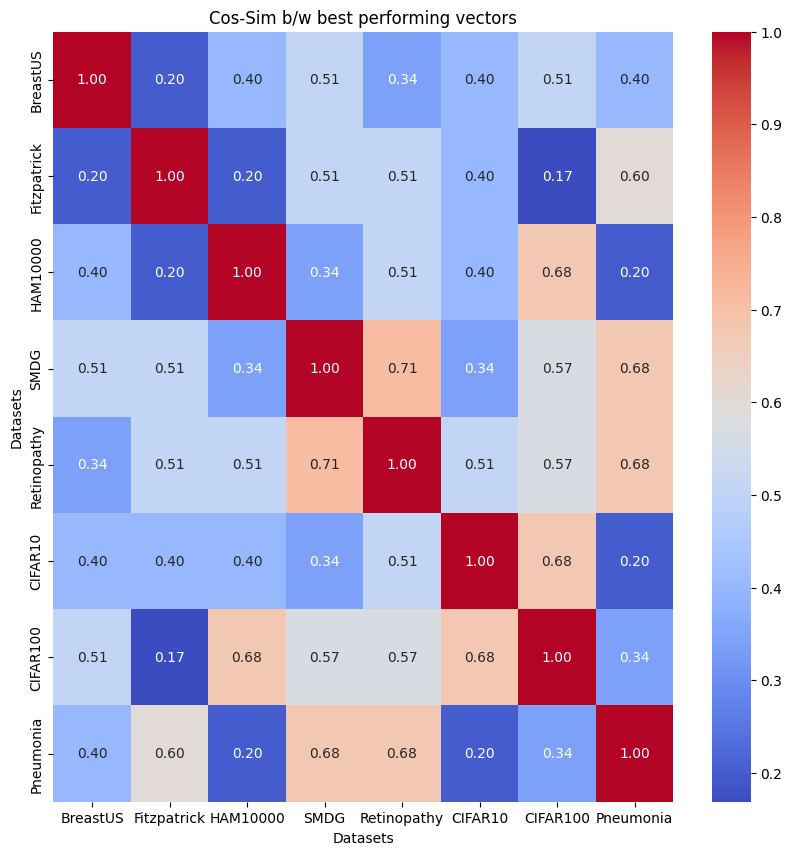

In [18]:
# Create a confusion matrix using seaborn and save it as a figure
tuning_method = 'tune_attention_blocks_random'
top_k = 10
datasets = ['BreastUS', 'Fitzpatrick', 'HAM10000', 'SMDG', 'Retinopathy', 'CIFAR10', 'CIFAR100', 'Pneumonia']
pos = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5]

plt.figure(figsize=(10, 10))

sns.heatmap(similarity_df_best, annot=True, fmt='.2f', cmap='coolwarm')
plt.xlabel("Datasets")
plt.ylabel("Datasets")
plt.xticks(pos, datasets)
plt.yticks(pos, datasets)
plt.title("Cos-Sim b/w best performing vectors")
plt.savefig('../plots/SSL_best_cosine_sim_{}.png'.format(tuning_method))

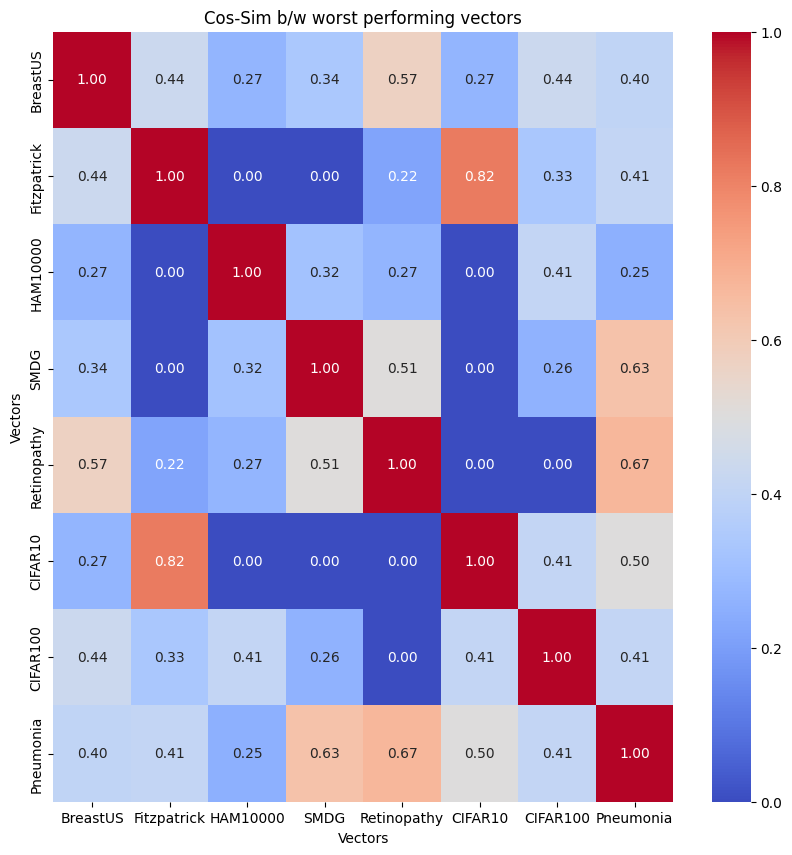

In [19]:
# Create a confusion matrix using seaborn and save it as a figure
tuning_method = 'tune_attention_blocks_random'
top_k = 10
datasets = ['BreastUS', 'Fitzpatrick', 'HAM10000', 'SMDG', 'Retinopathy', 'CIFAR10', 'CIFAR100', 'Pneumonia']
pos = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5]

plt.figure(figsize=(10, 10))

sns.heatmap(similarity_df_worst, annot=True, fmt='.2f', cmap='coolwarm')
plt.xlabel("Vectors")
plt.ylabel("Vectors")
plt.xticks(pos, datasets)
plt.yticks(pos, datasets)
plt.title("Cos-Sim b/w worst performing vectors")
plt.savefig('../plots/SSL_worst_cosine_sim_{}.png'.format(tuning_method))